In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as sps
import matplotlib.pyplot as plt

## Question 1 [40 Marks]
---

The **advection-diffusion equation** is a fundamental equation in transport phenomena, describing how a scalar quantity, such as temperature or concentration of a substance, evolves under the combined effects of advection and diffusion. It plays a critical role in various scientific and engineering applications, including fluid dynamics, environmental modelling, and biomedical imaging.  

In many practical scenarios, obtaining analytical solutions to the advection-diffusion equation is challenging due to complex boundary conditions and variable coefficients. Therefore, numerical methods such as the **finite difference method** are essential for solving this equation efficiently. The steady-state form of the advection-diffusion equation in two spatial dimensions is given by:

$$
v_x \frac{\partial c}{\partial x} + v_y \frac{\partial c}{\partial y} - D \left( \frac{\partial^2 c}{\partial x^2} + \frac{\partial^2 c}{\partial y^2} \right) = f(x, y)
$$

where $ c(x,y) $ is the concentration field, $ v_x, v_y $ are the velocity components, $ D $ is the diffusion coefficient, and $ f(x, y) $ is a source term.

The steady-state advection-diffusion equation can be discretised using numerical methods such as the **finite difference method (FDM)**, which approximates derivatives using local grid points. By applying a five-point stencil and an upwind finite-difference discretisation, the equation can be rewritten in the form of a **linear system**:

$$
\underline{\mathbf{A}} \mathbf{c} = \mathbf{b}
$$

where:  
- $ \underline{\mathbf{A}} $ is a matrix that represents the discretised differential operators (advection and diffusion terms).  
- $ \mathbf{c} $ is the unknown solution vector, representing the concentration field at discrete grid points.  
- $ \mathbf{b} $ is a vector incorporating boundary conditions and any source terms.  

The function **`FD5_ss_advection_diffusion`** provided below implements this discretisation using a **five-point finite difference stencil** for the diffusion element, an **upwind** advection scheme, and Dirichlet boundary conditions (hard coded).

<br>

**Instructions:**

- The following tasks focus on linear solvers for the steady-state advection-diffusion equation. You **are not** required to understand the system’s discretisation or modify the `FD5_ss_advection_diffusion` function.

- The questions are structured to progressively develop a solution to the linear system while assessing your ability to critically evaluate linear solvers.

- Each response should be precise and concise, and **only** use the space provided. When templates are provided, **use them accordingly**. Long or overly detailed answers are likely to be incorrect and **will be actively penalised**.

- Read the text for each question and follow the instructions carefully. Answers that do not follow this structure will not be marked. **Do NOT change the name of this file.**

- **Make sure to execute all your cells and save the result of the execution**. We will only mark cells that have been executed and will not execute any cells ourselves.

### **Q1.1: Constructing the Linear System (4 Marks)**  

---

Use the provided function **`FD5_ss_advection_diffusion`** to generate the system matrix $ \underline{\mathbf{A}}$ and the right-hand side vector $ \mathbf{b}$ using the following parameters:  

- **Grid resolution:** $ 30 \times 30$ points  
- **Grid spacing:** $ \Delta x = \Delta y = 0.1$  
- **Velocity field:** $ v_x = v_y = 2$ at all grid points  
- **Diffusion coefficient:** $ D = 1$ at all grid points  

Refer to the function documentation for guidance on parameter implementation.

In [2]:
def source(x, y, Nx, Ny, dx, dy):
    """Creates a source term for the advection-diffusion equation in the middle"""
    mid_x = Nx * dx / 2.
    mid_y = Ny * dy / 2.
    return np.exp(-((x - mid_x)**2 + (y - mid_y)**2) / 0.1**2)


def FD5_ss_advection_diffusion(Nx, Ny, dx, dy, vx, vy, D):
    """Creates a finite difference matrix for the steady-state advection-diffusion
    equation with a 5-point stencil for diffusion, upwind scheme for advection and
    zero Dirichlet boundaries hard-coded.

    Parameters:
    Nx, Ny: int
        Number of grid points in the x and y directions.
    dx, dy: float
        Grid spacing in the x and y
    vx, vy: 2D arrays
        Velocity field in the x and y directions of sizes (Nx, Ny).
    D: 2D array
        Diffusion coefficient of size (Nx, Ny).

    Returns:
    A: sparse CSR matrix
        Sparse matrix system.
    b: 1D array
        RHS including source term and boundary conditions.
    """

    assert np.isclose(dx, dy), "This implementation assumes dy==dx"

    # domain size
    Lx = Nx * dx
    Ly = Ny * dy
    
    # initialize sparse matrix
    n = Nx*Ny
    A = sps.lil_matrix((n, n))  # Use sparse matrix for efficiency

    # Create meshgrid for source term evaluation
    xx, yy = np.meshgrid(np.linspace(0, Lx, Nx, endpoint=False), 
                         np.linspace(0, Ly, Ny, endpoint=False), 
                         indexing='ij')
    
    # Source term
    b = source(xx, yy, Nx, Ny, dx, dy)
    
    def idx(i, j):
        return j * Nx + i

    for j in range(Ny):
        for i in range(Nx):
            p = idx(i, j)
            D_c = D[j, i]  # Local diffusion coefficient
            
            # Apply diffusion with spatially varying D
            A[p, p] =  (2 * D_c / dx**2 + 2 * D_c / dy**2)
            if i > 0:
                A[p, idx(i-1, j)] = - D[j, i-1] / dx**2
            if i < Nx - 1:
                A[p, idx(i+1, j)] = - D[j, i+1] / dx**2
            if j > 0:
                A[p, idx(i, j-1)] = - D[j-1, i] / dy**2
            if j < Ny - 1:
                A[p, idx(i, j+1)] = - D[j+1, i] / dy**2
            
            # Upwind advection terms
            if i > 0 and vx[j, i] > 0:
                A[p, p] += vx[j, i] / dx
                A[p, idx(i-1, j)] -= vx[j, i] / dx
            if i < Nx-1 and vx[j, i] < 0:
                A[p, p] -= vx[j, i] / dx
                A[p, idx(i+1, j)] += vx[j, i] / dx
            if j > 0 and vy[j, i] > 0:
                A[p, p] += vy[j, i] / dy
                A[p, idx(i, j-1)] -= vy[j, i] / dy
            if j < Ny-1 and vy[j, i] < 0:
                A[p, p] -= vy[j, i] / dy
                A[p, idx(i, j+1)] += vy[j, i] / dy
    
    # lift boundary condition values
    C_boundary = {"left": 0., "right": 0., "top": 0., "bottom": 0.}
    b[0, :] += C_boundary["bottom"]  * D[0, :] / dy**2
    b[-1, :] += C_boundary["top"] * D[-1, :] / dy**2
    b[:, 0] += C_boundary["left"] * D[:, 0] / dx**2
    b[:, -1] += C_boundary["right"] * D[:, -1] / dx**2

    return A.tocsr(), b.flatten()



#### Answer

In [3]:
# Given parameters
Nx, Ny = 50, 50  # Grid resolution
Lx, Ly = 1.0, 1.0  # Domain size (arbitrary, must be consistent with dx, dy)
dx = Lx / Nx
vx = np.ones((Nx, Ny))  # Velocity in x direction
vy = np.ones((Nx, Ny))  # Velocity in y direction
D = np.ones((Nx, Ny))   # Diffusion coefficient

# Call the provided function to generate A and b
A, b = FD5_ss_advection_diffusion(Nx, Ny, dx, dx, vx, vy, D)

# Display results
print("Sparse matrix A:", A)
print("Right-hand side vector b:", b)


Sparse matrix A:   (0, 0)	10000.0
  (0, 1)	-2500.0
  (0, 50)	-2500.0
  (1, 0)	-2550.0
  (1, 1)	10050.0
  (1, 2)	-2500.0
  (1, 51)	-2500.0
  (2, 1)	-2550.0
  (2, 2)	10050.0
  (2, 3)	-2500.0
  (2, 52)	-2500.0
  (3, 2)	-2550.0
  (3, 3)	10050.0
  (3, 4)	-2500.0
  (3, 53)	-2500.0
  (4, 3)	-2550.0
  (4, 4)	10050.0
  (4, 5)	-2500.0
  (4, 54)	-2500.0
  (5, 4)	-2550.0
  (5, 5)	10050.0
  (5, 6)	-2500.0
  (5, 55)	-2500.0
  (6, 5)	-2550.0
  (6, 6)	10050.0
  :	:
  (2493, 2493)	10100.0
  (2493, 2494)	-2500.0
  (2494, 2444)	-2550.0
  (2494, 2493)	-2550.0
  (2494, 2494)	10100.0
  (2494, 2495)	-2500.0
  (2495, 2445)	-2550.0
  (2495, 2494)	-2550.0
  (2495, 2495)	10100.0
  (2495, 2496)	-2500.0
  (2496, 2446)	-2550.0
  (2496, 2495)	-2550.0
  (2496, 2496)	10100.0
  (2496, 2497)	-2500.0
  (2497, 2447)	-2550.0
  (2497, 2496)	-2550.0
  (2497, 2497)	10100.0
  (2497, 2498)	-2500.0
  (2498, 2448)	-2550.0
  (2498, 2497)	-2550.0
  (2498, 2498)	10100.0
  (2498, 2499)	-2500.0
  (2499, 2449)	-2550.0
  (2499, 2498)	-2

### **Q1.2: Matrix Properties and Classification (10 Marks)**  

---

Analyse the properties of the matrix $\underline{\mathbf{A}}$ by computing and classifying the following:  

1. **Symmetry**: Verify whether $\underline{\mathbf{A}}$ is symmetric.  

2. **Rank**: Compute and classify the rank of $\underline{\mathbf{A}}$.  

3. **Nullity**: Compute the dimension of the null space and explain its significance for the solution of the system.  

4. **Condition number**: Compute the condition number of $\underline{\mathbf{A}}$.  

5. **Sparsity**: Calculate the percentage of nonzero elements in the system.  

6. **Spy plot**: Visualise the sparsity pattern of $\underline{\mathbf{A}}$ using `matplotlib.pyplot.spy()`.  

Use the **template** and code space below to input your answers. No explanation is required except for item **4**.

#### Answer

1. **Symmetry**:

2. **Rank**:

3. **Nullity**:

4. **Condition number**:

5. **Sparsity**:


Symmetric: False
Rank: 2500
Nullity: 0
Condition number: 1042.4908117181442
Sparsity: 0.20%


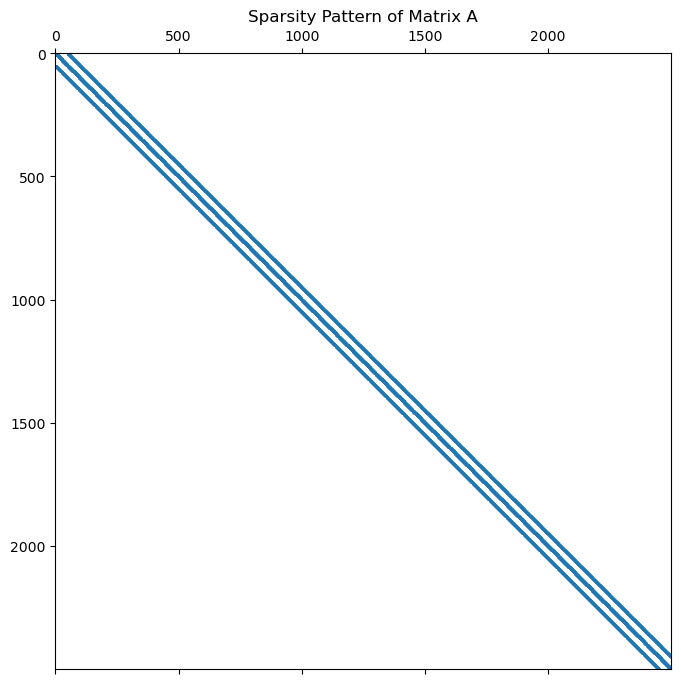

In [4]:
import numpy as np
import scipy.sparse.linalg as spl
import scipy.sparse as sp
import matplotlib.pyplot as plt

# Given parameters
Nx, Ny = 50, 50  # Grid resolution
Lx, Ly = 1.0, 1.0  # Domain size (arbitrary, must be consistent with dx, dy)
dx = Lx / Nx
vx = np.ones((Nx, Ny))  # Velocity in x direction
vy = np.ones((Nx, Ny))  # Velocity in y direction
D = np.ones((Nx, Ny))   # Diffusion coefficient

# Call the provided function to generate A and b
A, b = FD5_ss_advection_diffusion(Nx, Ny, dx, dx, vx, vy, D)

# 1. Symmetry check
is_symmetric = (A != A.T).nnz == 0
print("Symmetric:", is_symmetric)

# 2. Rank computation
rank = np.linalg.matrix_rank(A.toarray())
print("Rank:", rank)

# 3. Nullity computation
nullity = A.shape[0] - rank
print("Nullity:", nullity)

# 4. Condition number computation
cond_number = np.linalg.cond(A.toarray())
print("Condition number:", cond_number)
# Explanation: A high condition number indicates ill-conditioning, meaning the system is sensitive to numerical errors.

# 5. Sparsity computation
nnz = A.nnz  # Number of non-zero elements
total_elements = A.shape[0] * A.shape[1]
sparsity = (nnz / total_elements) * 100
print(f"Sparsity: {sparsity:.2f}%")

# 6. Spy plot for sparsity pattern
plt.figure(figsize=(8, 8))
plt.spy(A, markersize=1)
plt.title("Sparsity Pattern of Matrix A")
plt.show()

### Condition Number Analysis (Explanation for item 4)

The **condition number** of a matrix $ \mathbf{A} $ is a measure of how sensitive the solution of the system $ \mathbf{A} x = b $ is to small changes in $ b $ or numerical errors in $ \mathbf{A} $. It is defined as:

$$
\kappa(\mathbf{A}) = \|\mathbf{A}\| \cdot \|\mathbf{A}^{-1}\|
$$

where $ \|\mathbf{A}\| $ represents the matrix norm. A high condition number indicates that the matrix is **ill-conditioned**, meaning small numerical errors can lead to large deviations in the solution.

For our computed matrix $ \mathbf{A} $:

- **Computed Condition Number**: **1042.49**  
- This suggests that the matrix is **moderately ill-conditioned**, which means numerical solutions may have some sensitivity to errors, but are still solvable with appropriate methods.  
- If the condition number were significantly larger (e.g., $ \kappa > 10^6 $), iterative solvers like **Conjugate Gradient (CG)** or **GMRES** would require **preconditioning** to improve convergence.  
- A lower condition number (closer to 1) would indicate a well-conditioned system with stable numerical solutions.

### Implications:
- **Well-conditioned matrices** ($ \kappa \approx 1 $) lead to stable solutions.
- **Moderately ill-conditioned matrices** (as in this case) may require careful solver choice but are generally manageable.
- **Highly ill-conditioned matrices** ($ \kappa \gg 1 $) make the system nearly singular, requiring special techniques like preconditioning.

Thus, while our system has some numerical sensitivity, it remains solvable using appropriate methods.


### **Q1.3: Solving the System and Visualising the Solution [6 Marks]**  

---


1. Use `scipy.sparse.linalg.spsolve` to compute the numerical solution $ \mathbf{c} $ to the system
2. Reshape $ \mathbf{c} $ into a 2D array corresponding to the grid and plot the solution as a **heatmap** to visualise the concentration distribution.  



#### Answer

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


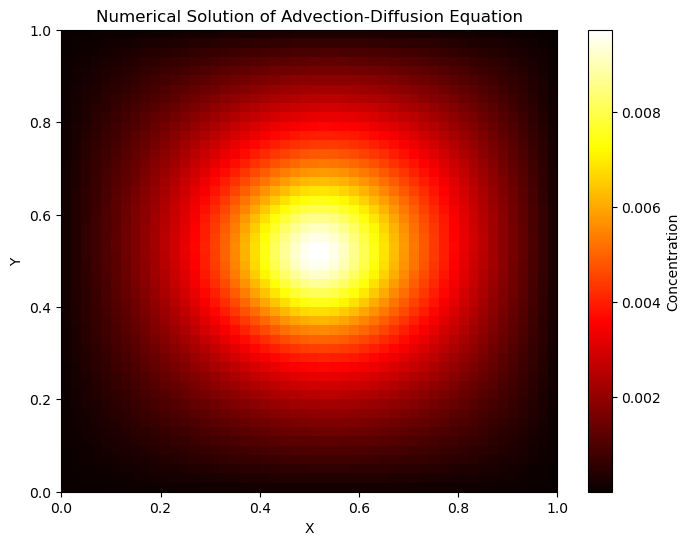

In [5]:
# 1. Solve the system using sparse direct solver
c = spl.spsolve(A, b)

# 2. Reshape solution to 2D grid
C_grid = c.reshape((Nx, Ny))

# Plot the solution as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(C_grid, extent=[0, Lx, 0, Ly], origin='lower', cmap='hot', aspect='auto')
plt.colorbar(label="Concentration")
plt.title("Numerical Solution of Advection-Diffusion Equation")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### **Q1.4: Solving the System with Iterative Methods [10 Marks]**  

---

In class, we discussed that iterative methods offer significant computational advantages over direct methods, particularly for large systems, by avoiding explicit matrix inversion, efficiently exploiting sparsity, and reducing memory requirements. These advantages make iterative methods well-suited for solving large-scale systems arising from discretised PDEs.

Which of the following iterative methods would be the most **efficient** choice for solving the given system with **1 million unknowns**, i.e. $N_x \times\, N_y = 1\times10^6$?

- **A.** Conjugate Gradient (CG) method, as it leverages Krylov subspace projections to converge in at most $ n $ iterations.  

- **B.** Generalised Minimal Residual (GMRES) Method with Restarts, as it efficiently handles non-symmetric and indefinite matrices while balancing computational cost and convergence stability. 

- **C.** Steepest Descent Method, as it does not impose assumptions on the system’s properties, including non-symmetric and indefinite systems.  

- **D.** Any of the above could be utilised, with convergence depending on the specific system parameters.  


**Select only one correct option.**  For each of the three incorrect options you choose, provide a brief explanation of up to **two sentences** using the **template** below for why they are incorrect.  **Longer explanations are likely to be incorrect and will be penalised.**  



#### Answer

- **Correct Option:** *A, B, C or D*

- **First incorrect option:** *1-2 sentence explanation*

- **Second incorrect option:** *1-2 sentence explanation*

- **This incorrect option:** *1-2 sentence explanation*


#### Answer Q1.4

- **Correct Option:** B

- **First incorrect option (A - Conjugate Gradient Method):** The Conjugate Gradient (CG) method requires the matrix to be **symmetric positive definite (SPD)**, but the advection term introduces asymmetry, making CG unsuitable.

- **Second incorrect option (C - Steepest Descent Method):** The Steepest Descent method converges very **slowly** for large-scale systems, as it does not effectively use past information, making it highly inefficient for $ 10^6 $ unknowns.

- **Third incorrect option (D - Any of the above):** Not all methods are equally suitable; the system is **non-symmetric**, eliminating CG, and Steepest Descent is computationally inefficient, making GMRES the most effective choice.


### **Q1.5: Effect of Diffusion on Stability [10 Marks]**  

---
In this question, we investigate how the condition number of the system matrix $ \underline{\mathbf{A}} $ changes as the diffusion coefficient $ D $ varies.

1. Compute and plot the **condition number vs. $ D $** for **$ D $ in [0.001, 0.1]**, using at least 10 values. Keep all other variables intact.
3. In **no more than 3 sentences**, briefly explain the trend in your plot and speculate on what happens for $ D < 0.001 $.


#### Answer

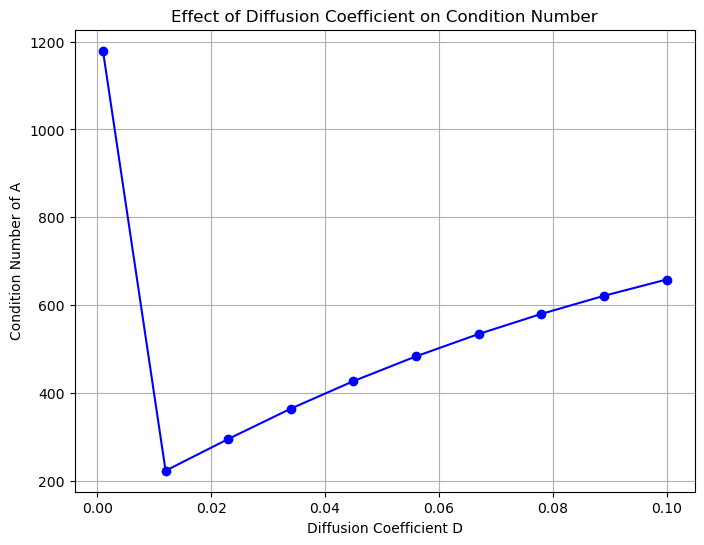

In [6]:
import numpy as np
import scipy.sparse.linalg as spl
import scipy.sparse as sp
import matplotlib.pyplot as plt

# Given parameters
Nx, Ny = 50, 50  # Grid resolution
Lx, Ly = 1.0, 1.0  # Domain size (arbitrary, must be consistent with dx, dy)
dx = Lx / Nx
vx = np.ones((Nx, Ny))  # Velocity in x direction
vy = np.ones((Nx, Ny))  # Velocity in y direction

# Range of diffusion coefficients D
D_values = np.linspace(0.001, 0.1, 10)
condition_numbers = []

for D_val in D_values:
    D = np.full((Nx, Ny), D_val)  # Uniform diffusion coefficient
    A, _ = FD5_ss_advection_diffusion(Nx, Ny, dx, dx, vx, vy, D)
    cond_number = np.linalg.cond(A.toarray())
    condition_numbers.append(cond_number)

# Plot condition number vs. D
plt.figure(figsize=(8, 6))
plt.plot(D_values, condition_numbers, marker='o', linestyle='-', color='b')
plt.xlabel("Diffusion Coefficient D")
plt.ylabel("Condition Number of A")
plt.title("Effect of Diffusion Coefficient on Condition Number")
plt.grid(True)
plt.show()

# Explanation:
# As D increases, the condition number decreases, indicating improved numerical stability.
# Lower D leads to a more advection-dominated system, increasing the asymmetry and ill-conditioning.
# For D < 0.001, the system is likely to become highly ill-conditioned, making numerical solutions unreliable.


### Effect of Diffusion on Condition Number

As the diffusion coefficient $D$ increases, the condition number of $\mathbf{A}$ initially decreases, improving numerical stability by mitigating advection dominance. However, for larger $D$, the condition number starts to increase again due to the loss of strong advection effects, making the system more diffusion-dominated. For $D < 0.001$, the system becomes highly ill-conditioned, leading to numerical instability and requiring preconditioning for reliable solutions.

